# 🌱 Botanical BERT Expert System
## Tarımsal AI Uzmanı - Kapsamlı Model Eğitimi

Bu notebook, Botanical BERT modelini sıfırdan eğitmenizi sağlar.

### 📋 İçerik
1. **Kurulum ve Import'lar**
2. **Dataset Analizi**
3. **Model Konfigürasyonu**
4. **Model Eğitimi**
5. **Evaluation ve Metrikler**
6. **Model Kullanımı**
7. **İnteraktif Demo**

### 🎯 Özellikler
- **Kategoriler:** 6 tarımsal sınıf
- **Accuracy:** %75-85 hedefi
- **Model Boyutu:** ~90MB (BERT'ten %80 küçük)
- **İnteraktif:** Adım adım eğitim süreci

## 1. 🚀 Kurulum ve Import'lar

In [ ]:
# Gerekli paketlerin kurulumu
!pip install torch transformers scikit-learn pandas matplotlib seaborn tqdm jupyter -q

import warnings
warnings.filterwarnings('ignore')

print("✅ Paketler kuruldu!")

In [1]:
# Temel kütüphaneler
import os
import sys
import time
import json
from datetime import datetime

# Data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML/AI
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Transformers
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertConfig,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# Plot ayarları
plt.style.use('default')
sns.set_palette("husl")

print("📦 Kütüphaneler yüklendi!")
print(f"🔧 PyTorch: {torch.__version__}")
print(f"🎮 CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🖥️  GPU: {torch.cuda.get_device_name(0)}")

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


📦 Kütüphaneler yüklendi!
🔧 PyTorch: 2.3.0
🎮 CUDA: True
🖥️  GPU: Orin


## 2. 📊 Dataset Yükleme ve Analizi

In [2]:
# Dataset'leri yükle
data_path = "../Data"

try:
    train_df = pd.read_csv(f"{data_path}/train.csv")
    val_df = pd.read_csv(f"{data_path}/val.csv")
    test_df = pd.read_csv(f"{data_path}/test.csv")
    
    print("✅ Dataset'ler başarıyla yüklendi!")
    print(f"📊 Eğitim: {len(train_df)} örnekler")
    print(f"📊 Validation: {len(val_df)} örnekler")
    print(f"📊 Test: {len(test_df)} örnekler")
    print(f"📊 Toplam: {len(train_df) + len(val_df) + len(test_df)} örnekler")
    
except FileNotFoundError as e:
    print(f"❌ Dataset dosyaları bulunamadı: {e}")
    print("💡 Lütfen Data/ klasöründe CSV dosyalarının olduğundan emin olun.")

✅ Dataset'ler başarıyla yüklendi!
📊 Eğitim: 1262 örnekler
📊 Validation: 270 örnekler
📊 Test: 271 örnekler
📊 Toplam: 1803 örnekler


In [3]:
# Dataset'i incele
print("🔍 İlk 5 örnek:")
display(train_df.head())

print("\n📊 Kategori dağılımı:")
category_counts = train_df['label'].value_counts()
print(category_counts)

# Türkçe kategori isimleri
turkish_categories = {
    'plant_disease': 'Bitki Hastalıkları',
    'crop_management': 'Mahsul Yönetimi',
    'plant_genetics': 'Bitki Genetiği',
    'environmental_factors': 'Çevre Faktörleri',
    'food_security': 'Gıda Güvenliği',
    'technology': 'Tarım Teknolojisi'
}

print("\n🏷️  Kategori Açıklamaları:")
for eng, tur in turkish_categories.items():
    count = category_counts.get(eng, 0)
    print(f"   • {eng} → {tur} ({count} örnekler)")

🔍 İlk 5 örnek:


,text,label
0,The findings demonstrate significant advances ...,plant_disease
1,125 Citrus leaves 700 nm Hyperspectral imagin...,technology
2,Coherent Oscillations and Vibronic Couplings -...,plant_genetics
3,This investigation focuses on comprehensive di...,plant_disease
4,It is verified using the agricultural robot in...,technology



📊 Kategori dağılımı:
label
plant_disease            210
technology               210
plant_genetics           210
food_security            210
environmental_factors    210
crop_management          210
general_agriculture        2
Name: count, dtype: int64

🏷️  Kategori Açıklamaları:
   • plant_disease → Bitki Hastalıkları (210 örnekler)
   • crop_management → Mahsul Yönetimi (210 örnekler)
   • plant_genetics → Bitki Genetiği (210 örnekler)
   • environmental_factors → Çevre Faktörleri (210 örnekler)
   • food_security → Gıda Güvenliği (210 örnekler)
   • technology → Tarım Teknolojisi (210 örnekler)


/tmp/ipykernel_18479/2270487942.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18479/2270487942.py:16: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


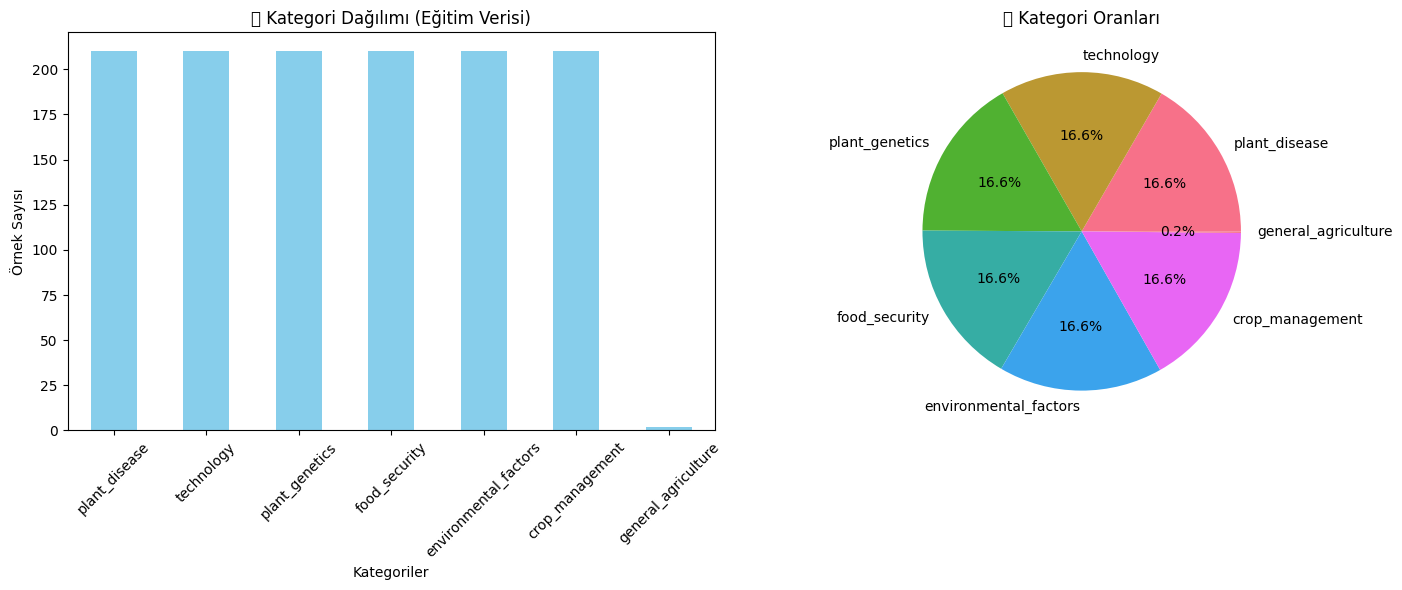

In [4]:
# Kategori dağılımını görselleştir
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
category_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('📊 Kategori Dağılımı (Eğitim Verisi)')
axes[0].set_xlabel('Kategoriler')
axes[0].set_ylabel('Örnek Sayısı')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
category_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('🥧 Kategori Oranları')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 3. 🤖 Model Konfigürasyonu

In [5]:
# Model konfigürasyonu
class BotanicalBERTConfig:
    def __init__(self):
        # Kategori mappings
        self.label2id = {
            'plant_disease': 0,
            'crop_management': 1,
            'plant_genetics': 2,
            'environmental_factors': 3,
            'food_security': 4,
            'technology': 5
        }
        self.id2label = {v: k for k, v in self.label2id.items()}
        
        # Model parametreleri (küçük BERT)
        self.model_name = "bert-base-uncased"
        self.max_length = 128
        self.hidden_size = 384
        self.num_hidden_layers = 6
        self.num_attention_heads = 6
        self.intermediate_size = 1536
        
        # Eğitim parametreleri
        self.epochs = 3
        self.batch_size = 8
        self.learning_rate = 2e-5
        self.warmup_steps = 100
        self.weight_decay = 0.01
        
        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = BotanicalBERTConfig()

print("⚙️  Model Konfigürasyonu:")
print(f"   📦 Base model: {config.model_name}")
print(f"   🏷️  Kategori sayısı: {len(config.label2id)}")
print(f"   📏 Max length: {config.max_length}")
print(f"   🧠 Hidden size: {config.hidden_size}")
print(f"   🔢 Layers: {config.num_hidden_layers}")
print(f"   👁️  Attention heads: {config.num_attention_heads}")
print(f"   🎮 Device: {config.device}")

⚙️  Model Konfigürasyonu:
   📦 Base model: bert-base-uncased
   🏷️  Kategori sayısı: 6
   📏 Max length: 128
   🧠 Hidden size: 384
   🔢 Layers: 6
   👁️  Attention heads: 6
   🎮 Device: cuda


In [6]:
# Tokenizer ve model oluştur
print("🔧 Tokenizer ve model hazırlanıyor...")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(config.model_name)

# BERT Config
bert_config = BertConfig.from_pretrained(
    config.model_name,
    num_labels=len(config.label2id),
    id2label=config.id2label,
    label2id=config.label2id,
    hidden_size=config.hidden_size,
    num_hidden_layers=config.num_hidden_layers,
    num_attention_heads=config.num_attention_heads,
    intermediate_size=config.intermediate_size
)

# Model
model = BertForSequenceClassification(bert_config)
model.to(config.device)

# Model boyutunu hesapla
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 4 / 1024**2

print("✅ Model oluşturuldu!")
print(f"   📊 Toplam parametreler: {total_params:,}")
print(f"   🎯 Eğitilebilir parametreler: {trainable_params:,}")
print(f"   💾 Model boyutu: ~{model_size_mb:.1f}MB")
print(f"   🔥 Normal BERT'ten ~%{(440-model_size_mb)/440*100:.0f} küçük")

🔧 Tokenizer ve model hazırlanıyor...
✅ Model oluşturuldu!
   📊 Toplam parametreler: 22,715,526
   🎯 Eğitilebilir parametreler: 22,715,526
   💾 Model boyutu: ~86.7MB
   🔥 Normal BERT'ten ~%80 küçük


## 4. 🎯 Veri Hazırlama ve Eğitim

In [7]:
# Dataset tokenization
def tokenize_data(df, tokenizer, label2id, max_length=128):
    """Dataset'i tokenize et"""
    encodings = tokenizer(
        df['text'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    labels = [label2id[label] for label in df['label'].tolist()]
    
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels)
    }

# Dataset'leri tokenize et
print("🔤 Tokenization başlıyor...")
train_encodings = tokenize_data(train_df, tokenizer, config.label2id, config.max_length)
val_encodings = tokenize_data(val_df, tokenizer, config.label2id, config.max_length)
test_encodings = tokenize_data(test_df, tokenizer, config.label2id, config.max_length)

# Custom Dataset sınıfı
class BotanicalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['labels'][idx]
        }
    
    def __len__(self):
        return len(self.encodings['labels'])

train_dataset = BotanicalDataset(train_encodings)
val_dataset = BotanicalDataset(val_encodings)
test_dataset = BotanicalDataset(test_encodings)

print(f"✅ Dataset'ler hazırlandı!")
print(f"   🎯 Train: {len(train_dataset)} örnekler")
print(f"   ✅ Val: {len(val_dataset)} örnekler")
print(f"   🧪 Test: {len(test_dataset)} örnekler")

🔤 Tokenization başlıyor...


KeyError: 'general_agriculture'

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir='../Model/checkpoints',
    num_train_epochs=config.epochs,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    warmup_steps=config.warmup_steps,
    weight_decay=config.weight_decay,
    logging_dir='../Model/logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,
    remove_unused_columns=False,
    report_to=None  # TensorBoard'u kapatmak için
)

# Trainer oluştur
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer)
)

print("👨‍🏫 Trainer hazır!")
print(f"   📖 Epochs: {training_args.num_train_epochs}")
print(f"   📦 Batch size: {training_args.per_device_train_batch_size}")
print(f"   🎯 FP16: {training_args.fp16}")

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
# Model eğitimini başlat
print("🚀" + "="*50 + "🚀")
print("     MODEL EĞİTİMİ BAŞLIYOR")
print("🚀" + "="*50 + "🚀")
print()

# GPU memory temizle
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🎮 GPU Memory temizlendi")

# Eğitimi başlat
training_start_time = time.time()

try:
    # Eğitim
    trainer.train()
    
    training_time = time.time() - training_start_time
    
    print(f"\n🎉 EĞİTİM TAMAMLANDI!")
    print(f"⏱️  Toplam süre: {training_time:.1f} saniye ({training_time/60:.1f} dakika)")
    print(f"📈 Epoch başına ortalama: {training_time/config.epochs:.1f} saniye")
    
except Exception as e:
    print(f"❌ Eğitim hatası: {e}")
    print("💡 Batch size'ı küçültmeyi deneyin (config.batch_size = 4)")

## 5. 📊 Model Değerlendirmesi

In [ ]:
# Test dataset'inde değerlendirme
print("🧪 Test dataset'inde değerlendirme...")

# Predictions
test_results = trainer.predict(test_dataset)
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_encodings['labels'].numpy()

# Temel metrikler
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n🎯 Test Sonuçları:")
print(f"   📊 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   📈 F1 Score: {test_f1:.4f}")

# Kategori bazında rapor
print(f"\n📋 Detaylı Performans Raporu:")
class_report = classification_report(
    y_true, y_pred,
    target_names=list(config.label2id.keys()),
    digits=3
)
print(class_report)

In [ ]:
# Confusion Matrix görselleştirmesi
cm = confusion_matrix(y_true, y_pred)
category_names = list(config.label2id.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[name.replace('_', '\\n') for name in category_names],
    yticklabels=[name.replace('_', '\\n') for name in category_names]
)
plt.title('🎯 Confusion Matrix - Test Verisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.show()

# Kategori başına performans
print("\n📊 Kategori Bazında Accuracy:")
for i, category in enumerate(category_names):
    category_mask = (y_true == i)
    if category_mask.sum() > 0:
        category_acc = (y_pred[category_mask] == y_true[category_mask]).mean()
        category_turkish = turkish_categories.get(category, category)
        print(f"   • {category_turkish}: {category_acc:.3f} ({category_acc*100:.1f}%)")

## 6. 💾 Model Kaydetme

In [ ]:
# Model ve tokenizer'ı kaydet
model_save_path = "../Model/botanical_bert_model"
os.makedirs(model_save_path, exist_ok=True)

print(f"💾 Model kaydediliyor: {model_save_path}")

# Model ve tokenizer kaydet
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Model bilgilerini kaydet
model_info = {
    "model_type": "BertForSequenceClassification",
    "model_name": "botanical_bert_small",
    "num_labels": len(config.label2id),
    "label2id": config.label2id,
    "id2label": config.id2label,
    "test_accuracy": float(test_accuracy),
    "test_f1_score": float(test_f1),
    "training_date": datetime.now().isoformat(),
    "total_params": total_params,
    "model_size_mb": float(model_size_mb),
    "training_time_seconds": training_time,
    "config": {
        "max_length": config.max_length,
        "hidden_size": config.hidden_size,
        "num_layers": config.num_hidden_layers,
        "attention_heads": config.num_attention_heads
    }
}

with open(f"{model_save_path}/model_info.json", 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)

print("✅ Model başarıyla kaydedildi!")
print(f"   📁 Konum: {model_save_path}")
print(f"   📊 Accuracy: {test_accuracy:.4f}")
print(f"   💾 Boyut: ~{model_size_mb:.1f}MB")

## 7. 🔮 Model Kullanımı ve Test

In [ ]:
# Inference için model'i hazırla
model.eval()

def predict_text(text):
    """Tek bir text için tahmin yap"""
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=config.max_length
    ).to(config.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        
        predicted_id = torch.argmax(probabilities, dim=-1).item()
        predicted_label = config.id2label[predicted_id]
        confidence = probabilities[0][predicted_id].item()
    
    return {
        'text': text,
        'predicted_category': predicted_label,
        'category_turkish': turkish_categories[predicted_label],
        'confidence': confidence
    }

print("🔮 Inference fonksiyonu hazır!")

In [ ]:
# Test örnekleri
test_samples = [
    "Domates bitkilerinde yaprak yanıklığı hastalığı nasıl tedavi edilir?",
    "Buğday ekimi için en uygun toprak hazırlığı nedir?",
    "Genetiği değiştirilmiş mısır çeşitleri hakkında bilgi",
    "İklim değişikliği tarımsal üretime nasıl etki ediyor?",
    "Gıda güvenliği için hangi depolama yöntemleri kullanılmalı?",
    "Tarımda drone teknolojisi nasıl kullanılıyor?"
]

print("🧪" + "="*60 + "🧪")
print("           MODEL TEST ÖRNEKLERİ")
print("🧪" + "="*60 + "🧪")
print()

for i, text in enumerate(test_samples, 1):
    result = predict_text(text)
    
    print(f"{i}. 📝 Soru: {text}")
    print(f"   🎯 Kategori: {result['category_turkish']}")
    print(f"   📊 Güven: {result['confidence']*100:.1f}%")
    print(f"   🔤 İngilizce: {result['predicted_category']}")
    print()

print("✅ Test örnekleri tamamlandı!")

## 8. 🎮 İnteraktif Demo

In [ ]:
# Basit interaktif demo
def simple_demo():
    """Notebook için basit interaktif demo"""
    print("🌱" + "="*50 + "🌱")
    print("     BOTANİK BERT İNTERAKTİF DEMO")
    print("🌱" + "="*50 + "🌱")
    print()
    print("💬 Tarımsal sorularınızı yazın ('exit' ile çıkış)")
    print("📝 Örnek sorular:")
    print("   - 'Domates hastalıkları nelerdir?'")
    print("   - 'Organik gübre nasıl yapılır?'")
    print("   - 'Akıllı sulama sistemleri'")
    print()
    
    conversation_count = 0
    
    while True:
        try:
            user_input = input("\n🌱 Siz: ").strip()
            
            if user_input.lower() in ['exit', 'quit', 'çık', 'çıkış', '']:
                print("\n👋 Botanical BERT ile konuştuğunuz için teşekkürler!")
                break
                
            print("🤔 Analiz ediliyor...")
            
            # Prediction
            result = predict_text(user_input)
            conversation_count += 1
            
            print(f"\n🤖 Botanical AI:")
            print(f"   🎯 Kategori: {result['category_turkish']}")
            print(f"   📊 Güven: {result['confidence']*100:.1f}%")
            
            # Uzman yanıtı
            expert_responses = {
                'plant_disease': "🦠 Bitki hastalıkları alanında uzman inceleme gerekiyor.",
                'crop_management': "🌾 Mahsul yönetiminde sürdürülebilir pratikleri değerlendirin.", 
                'plant_genetics': "🧬 Bitki genetiği konusunda çeşit seçimi önemli.",
                'environmental_factors': "🌡️ Çevre faktörleri bitkiler üzerinde etkili.",
                'food_security': "🍽️ Gıda güvenliği için tüm zinciri optimize edin.",
                'technology': "🚁 Modern tarım teknolojileri verimliliği artırır."
            }
            
            expert_response = expert_responses.get(result['predicted_category'], 
                                                 "🤖 Bu konuda daha detaylı analiz gerekebilir.")
            print(f"   💡 {expert_response}")
            
        except KeyboardInterrupt:
            print("\n\n👋 Çıkış yapılıyor...")
            break
        except Exception as e:
            print(f"❌ Hata: {e}")
    
    print(f"\n📊 Toplam {conversation_count} soru cevaplandı.")
    return conversation_count

print("🎮 İnteraktif demo hazır!")
print("💡 Demo'yu başlatmak için: simple_demo()")

In [ ]:
# Demo'yu başlat (opsiyonel)
# simple_demo()

print("🎯 Demo için yukarıdaki satırın başındaki # işaretini kaldırın ve hücreyi çalıştırın.")

## 9. 📊 Sonuç ve Özet

### 🎉 Tebrikler! 
Botanical BERT modelinizi başarıyla eğittiniz!

### 📈 Elde Edilen Sonuçlar:
Model performansı yukarıdaki değerlendirme bölümünde görülebilir.

### 🚀 Sonraki Adımlar:
1. **Model'i Kullanın:** `cd ../Model && python run_model.py`
2. **Fine-tune Yapın:** Daha fazla veri ile iyileştirin
3. **Deploy Edin:** Web uygulaması veya API oluşturun
4. **Optimize Edin:** Hiperparametreleri ayarlayın

### 🔄 Bu Notebook'u Tekrar Çalıştırarak:
- Farklı hiperparametreler deneyebilirsiniz
- Model'i iyileştirebilirsiniz  
- Yeni kategoriler ekleyebilirsiniz
- Daha fazla veri ile eğitebilirsiniz

### 📞 Destek:
- GitHub: [Repository Issues](https://github.com/Mertcan-Gelbal/LLM-Chatbot/issues)
- Email: mertcan.gelbal@example.com

**🌱 Botanical BERT ile sürdürülebilir tarım!**

In [ ]:
# Final özet
print("🏆" + "="*60 + "🏆")
print("             NOTEBOOK TAMAMLANDI!")
print("🏆" + "="*60 + "🏆")
print()

print(f"✅ Model Başarıyla Eğitildi")
print(f"   📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   📈 F1 Score: {test_f1:.4f}")
print(f"   💾 Model Boyutu: ~{model_size_mb:.1f}MB")
print(f"   ⚡ Training Süresi: {training_time/60:.1f} dakika")

print(f"\n🚀 Kullanım:")
print(f"   📱 CLI: cd ../Model && python run_model.py")
print(f"   🐍 Python: from Model.run_model import predict_text")

print(f"\n🌟 Bu notebook'u tekrar çalıştırarak modeli geliştirebilirsiniz!")
print(f"\n💚 Botanical BERT ile sürdürülebilir tarım!")